In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from sklearn.preprocessing import MinMaxScaler
notebookstart= time.time()

In [2]:
from tensorflow import keras
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
import yfinance as yf

In [3]:
#Load data:
tickers_list = ['NG=F', 'CL=F', 'CADJPY=X']
df = yf.download(tickers_list,'2015-1-1')['Adj Close']
df = df.rename(columns={'NG=F': 'Gas', 'CL=F': 'Oil', 'CADJPY=X': 'CADJPY'}) #To rename variables
df = df.dropna() #To drop all rows with a null value.
df

[*********************100%***********************]  3 of 3 completed


,CADJPY,Oil,Gas
Date,,,
2014-12-31,102.910004,53.270000,2.889
2015-01-02,103.160004,52.689999,3.003
2015-01-05,102.098000,50.040001,2.882
2015-01-06,101.543999,47.930000,2.938
2015-01-07,100.210999,48.650002,2.871
...,...,...,...
2022-06-22,105.353996,106.190002,6.858
2022-06-23,104.918999,104.269997,6.239
2022-06-24,103.818001,107.620003,6.220


In [6]:
# Check for null values
print(df.isnull().any())

CADJPY    False
Oil       False
Gas       False
dtype: bool


In [7]:
#split data
train_size = int(len(df)*0.80)
test_size = len(df)-train_size

train,test = df.iloc[0:train_size],df.iloc[train_size:len(df)]
print(len(train),len(test))

1507 377


In [8]:
#split data
from sklearn.preprocessing import RobustScaler

F_col = ['Gas', 'Oil']

Rs = MinMaxScaler()
Rs_t = MinMaxScaler()
Rs = Rs.fit(train[F_col].to_numpy())
Rs_t = Rs_t.fit(train[['CADJPY']])
train.loc[:,F_col] = Rs.transform(train[F_col].to_numpy())
train['CADJPY'] = Rs_t.transform(train[['CADJPY']])


test.loc[:,F_col] = Rs.transform(test[F_col].to_numpy())
test['CADJPY'] = Rs_t.transform(test[['CADJPY']])

C:\Users\ams40\AppData\Local\Temp\ipykernel_3732\2840614488.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:,F_col] = Rs.transform(train[F_col].to_numpy())
C:\Users\ams40\AppData\Local\Temp\ipykernel_3732\2840614488.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['CADJPY'] = Rs_t.transform(train[['CADJPY']])
C:\Users\ams40\AppData\Local\Temp\ipykernel_3732\2840614488.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [9]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.CADJPY, time_steps)
X_test, y_test = create_dataset(test, test.CADJPY, time_steps)

print(X_train.shape, y_test.shape)

(1497, 10, 3) (367,)


In [11]:
X_test.view()

array([[[0.21004519, 0.75543667, 0.31505218],
        [0.21937914, 0.74754469, 0.32757083],
        [0.20311178, 0.76780075, 0.36363635],
        ...,
        [0.23320106, 0.79656258, 0.37883758],
        [0.23727668, 0.79393193, 0.37108794],
        [0.24184848, 0.79971937, 0.35290609]],

       [[0.21937914, 0.74754469, 0.32757083],
        [0.20311178, 0.76780075, 0.36363635],
        [0.21484249, 0.77393896, 0.36780928],
        ...,
        [0.23727668, 0.79393193, 0.37108794],
        [0.24184848, 0.79971937, 0.35290609],
        [0.25219721, 0.78910907, 0.37406856]],

       [[0.20311178, 0.76780075, 0.36363635],
        [0.21484249, 0.77393896, 0.36780928],
        [0.22675085, 0.77569273, 0.37168409],
        ...,
        [0.24184848, 0.79971937, 0.35290609],
        [0.25219721, 0.78910907, 0.37406856],
        [0.22607108, 0.79454575, 0.31713861]],

       ...,

       [[1.09395354, 1.38810937, 2.19612537],
        [1.07697749, 1.39038929, 2.12429223],
        [1.03366873, 1

In [12]:
model = keras.Sequential()
model.add(
    keras.layers.LSTM(
      units=32, 
      input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = False
    )
  )

model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1,kernel_regularizer='l1'))
model.compile(loss='mean_squared_error', optimizer='SGD', metrics = ['mse'])

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=14,
    #steps_per_epoch = 12,
    callbacks = early_stopping,
    validation_split= 0.2,
    shuffle=False
)

Epoch 1/20
86/86 [==============================] - 10s 22ms/step - loss: 0.1162 - mse: 0.0419 - val_loss: 0.0812 - val_mse: 0.0086
Epoch 2/20
86/86 [==============================] - 1s 9ms/step - loss: 0.0932 - mse: 0.0220 - val_loss: 0.0772 - val_mse: 0.0077
Epoch 3/20
86/86 [==============================] - 1s 9ms/step - loss: 0.0869 - mse: 0.0187 - val_loss: 0.0731 - val_mse: 0.0065
Epoch 4/20
86/86 [==============================] - 1s 8ms/step - loss: 0.0819 - mse: 0.0165 - val_loss: 0.0692 - val_mse: 0.0052
Epoch 5/20
86/86 [==============================] - 1s 9ms/step - loss: 0.0764 - mse: 0.0135 - val_loss: 0.0657 - val_mse: 0.0043
Epoch 6/20
86/86 [==============================] - 1s 9ms/step - loss: 0.0725 - mse: 0.0121 - val_loss: 0.0634 - val_mse: 0.0044
Epoch 7/20
86/86 [==============================] - 1s 9ms/step - loss: 0.0692 - mse: 0.0112 - val_loss: 0.0604 - val_mse: 0.0038
Epoch 8/20
86/86 [==============================] - 1s 9ms/step - loss: 0.0651 - mse: 0.

In [14]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


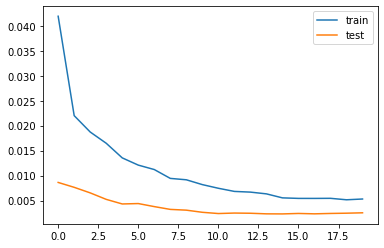

In [16]:
# plot performance
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend();

In [17]:
y_pred = model.predict(X_test)
print(y_pred.shape)

12/12 [==============================] - 1s 4ms/step
(367, 1)


In [18]:
y_train_inv = Rs_t.inverse_transform(y_train.reshape(1,-1))
y_test_inv = Rs_t.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = Rs_t.inverse_transform(y_pred)

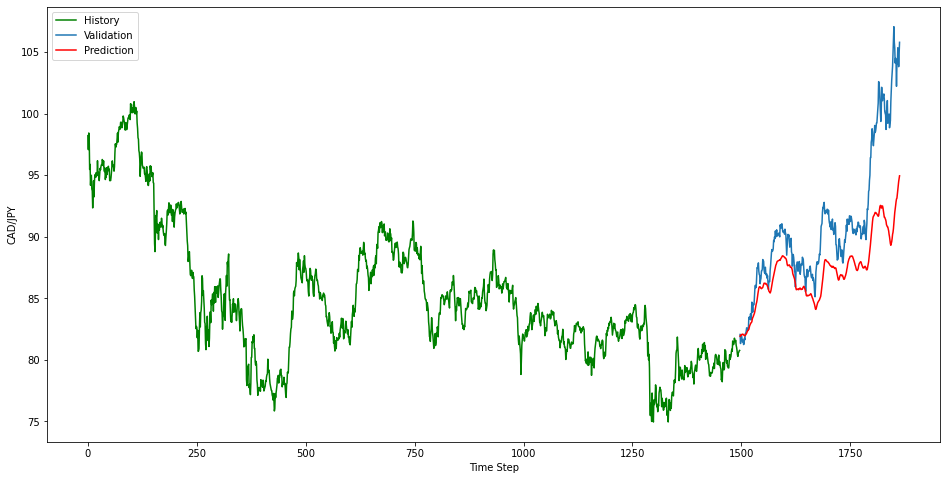

In [23]:
plt.figure(figsize=(16,8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), label="Validation")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="Prediction")
plt.ylabel('CAD/JPY')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [24]:
# Add 2nd layer:
model2 = keras.models.Sequential()

model2.add(keras.layers.LSTM(units=32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
model2.add(keras.layers.LSTM(128, activation = 'tanh',dropout = 0.4))
model2.add(keras.layers.Dense(units=1,kernel_regularizer='l1'))
model2.compile(loss='mean_squared_error', optimizer='SGD', metrics = ['mse'])

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
history2 = model2.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=14,
    #steps_per_epoch = 12,
    callbacks = early_stopping,
    validation_split= 0.2,
    shuffle=False
)

Epoch 1/30
86/86 [==============================] - 13s 41ms/step - loss: 0.1763 - mse: 0.0384 - val_loss: 0.1396 - val_mse: 0.0075
Epoch 2/30
86/86 [==============================] - 2s 21ms/step - loss: 0.1502 - mse: 0.0226 - val_loss: 0.1292 - val_mse: 0.0074
Epoch 3/30
86/86 [==============================] - 2s 25ms/step - loss: 0.1388 - mse: 0.0211 - val_loss: 0.1191 - val_mse: 0.0069
Epoch 4/30
86/86 [==============================] - 2s 26ms/step - loss: 0.1285 - mse: 0.0202 - val_loss: 0.1099 - val_mse: 0.0068
Epoch 5/30
86/86 [==============================] - 2s 24ms/step - loss: 0.1190 - mse: 0.0194 - val_loss: 0.1015 - val_mse: 0.0069
Epoch 6/30
86/86 [==============================] - 4s 43ms/step - loss: 0.1095 - mse: 0.0181 - val_loss: 0.0932 - val_mse: 0.0066
Epoch 7/30
86/86 [==============================] - 2s 25ms/step - loss: 0.1010 - mse: 0.0173 - val_loss: 0.0856 - val_mse: 0.0066
Epoch 8/30
86/86 [==============================] - 4s 42ms/step - loss: 0.0935 - 

In [26]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10, 32)            4608      
                                                                 
 lstm_2 (LSTM)               (None, 128)               82432     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 87,169
Trainable params: 87,169
Non-trainable params: 0
_________________________________________________________________


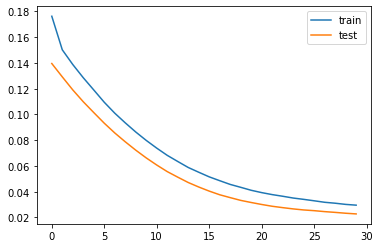

In [27]:
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend();

In [28]:
y_pred2 = model2.predict(X_test)
print(y_pred.shape)

12/12 [==============================] - 2s 10ms/step
(367, 1)


In [29]:
y_train_inv2 = Rs_t.inverse_transform(y_train.reshape(1,-1))
y_test_inv2 = Rs_t.inverse_transform(y_test.reshape(1,-1))
y_pred_inv2 = Rs_t.inverse_transform(y_pred2)

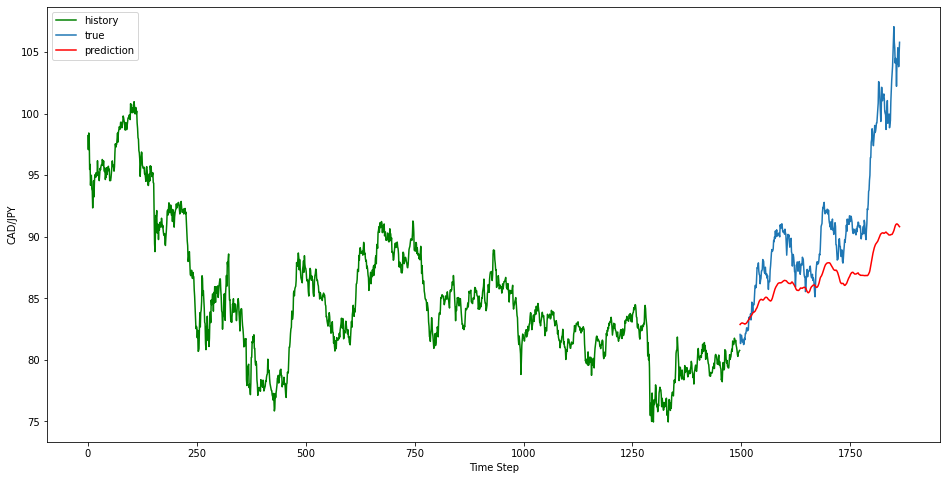

In [31]:
plt.figure(figsize=(16,8))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv2.flatten(), label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv2.flatten(), 'r', label="prediction")
plt.ylabel('CAD/JPY')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [32]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = (np.mean(np.abs((actual-predictions)/actual))*100)
    mae = np.mean(errors)*100
    print(model_name + ':')
    
    #print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    #print('Mean squered Error:{:.4f}'.format(mse))
    print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
    print('Mean Percentage Error: {:.4f}'.format(mae))
    
evaluate_prediction(y_pred, y_test, 'LSTM 1 layer')

evaluate_prediction(y_pred2, y_test, 'LSTM 2 layer')

LSTM 1 layer:
Root Mean Square Error: 0.2540
Mean Absolute Percentage Error: 30.8872
Mean Percentage Error: -12.6180
LSTM 2 layer:
Root Mean Square Error: 0.2578
Mean Absolute Percentage Error: 30.2863
Mean Percentage Error: -14.7947
